In [154]:
## remember to run conn_cocolab from the terminal before running cells in this notebook!
import os
import urllib, cStringIO

import pymongo as pm

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')

import numpy as np
from __future__ import division
import scipy.stats as stats
import pandas as pd
import json
import re

from PIL import Image
import base64

### vgg feature analysis 

In [2]:
import torch
import torchvision.models as models
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable

import scipy.stats as stats
from scipy.stats import norm
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm
from sklearn import linear_model, datasets, neighbors

from glob import glob
import os

import embedding as emb
reload(emb)
from embedding import *

In [3]:
# retrieve sketch paths
def list_files(path, ext='png'):
    result = [y for x in os.walk(path) for y in glob(os.path.join(x[0], '*.%s' % ext))]
    return result

# extract metadata
path_to_sketches = '../sketches'
sketch_paths = sorted(list_files(path_to_sketches))

In [4]:
## number of sketch paths 
print 'Number of sketch paths = {}'.format(len(sketch_paths))

Number of sketch paths = 532


## extract features

**Dec 28 2017:** <br>
 - From command line, extract features using `extract_features.py`. The default arguments are for the kid's drawings. <br>
 - To extract kid's drawings, just run: `python extract_features.py` <br>
 - To extract adult drawings, run: `python extract_features.py --data='/data2/jefan/quickDraw/png' --layer_ind=6 --cohort='adult'`

In [5]:
# z-score normalization to "center" the sketch embeddings
def normalize(X):
    X = X - X.mean(0)
    X = X / np.maximum(X.std(0), 1e-5)
    return X

def get_class_means(X, labels):    
    # load in and normalize features 
    _mu = np.zeros((len(np.unique(labels)), np.shape(X)[1]))        
    X = normalize(X)
    for vi, v in enumerate(np.unique(np.asarray(labels))):
        Xv = X[labels == v]
        nv = float(Xv.shape[0])
        if nv > 0:
            _mu[vi] = Xv.mean(0)
    return _mu

def normalize_RDM(MAT):
    X = MAT - MAT.mean(0).mean(0)
    X = X / np.maximum(MAT.std(0).std(0), 1e-5)
    return X

def plot_rdm_by_class(Features,X,layer_num):
    layers = ['P1','P2','P3','P4','P5','FC6','FC7']        
    sns.set_style('white')
    fig = plt.figure(figsize=(6,6))
    labels = X.label.values
    means = get_class_means(Features, labels)
    CORRMAT = np.corrcoef(means)
    plt.matshow(CORRMAT)
    plt.colorbar()
    if not os.path.exists('./plots'):
        os.makedirs('./plots')
    plt.savefig('./plots/RDM_by_view_{}.pdf'.format(layers[layer_num]))

In [6]:
def load_features(cohort, layer_num):
    layers = ['P1','P2','P3','P4','P5','FC6','FC7']            
    F = np.load('./features/FEATURES_{}_{}.npy'.format(layers[layer_num],cohort))
    M = pd.read_csv('./features/METADATA_{}.csv'.format(cohort)) 
    M = M[['label','age','session']]
    return F, M

def remove_practice_trials(KF,KM):
    '''
    remove "circle" and "triangle" trials from dataset
    '''
    practice_objects = ['circle','triangle']
    _KF = KF[~KM['label'].isin(practice_objects),:]
    _KM = KM[~KM['label'].isin(practice_objects)]
    return _KF, _KM

## load in kid features
KF, KM = load_features('kid',6)
KF, KM = remove_practice_trials(KF, KM)
KM = KM.reset_index(drop=True)

print np.shape(KF)

(387, 4096)


### quick classification test

In [7]:
#### Quick classification test
FEAT = KF
LABELS = KM.label.values
AGES = KM.age.values

# single train/test split
X_train, X_test, y_train, y_test = train_test_split(
    FEAT, LABELS, test_size=0.25, random_state=0)
# clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
clf = linear_model.LogisticRegression(penalty='l2',C=1).fit(X_train, y_train)
print clf.score(X_test, y_test)

run_this = 0
if run_this:
    # cross-validated
    clf = linear_model.LogisticRegression(penalty='l2')
    scores = cross_val_score(clf, FEAT, LABELS, cv=3)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

0.319587628866


In [288]:
## see how recognizability changes with age?

scores = []
num_samples = []
age_range = np.arange(4,11)


# width of moving window in # of trials    
window_size = 2
lb = int(min(_Y.age.values))
ub = int(max(_Y.age.values))
num_windows = ub-lb-window_size+2 ##     

for n in np.arange(num_windows):
    start = lb + n
    end = lb + n + window_size
    ind = _Y.index[(_Y['age'] >= start) & (_Y['age'] < end)]
    meta = _Y.loc[ind]
    subFeat = _Features[ind.tolist()]

    FEAT = subFeat
    LABELS = meta.label.values

    # single train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        FEAT, LABELS, test_size=0.5, random_state=0)
#     clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
    clf = linear_model.LogisticRegression(penalty='l2',C=1).fit(X_train, y_train)
    print '{}-{}y'.format(start, end-1), len(LABELS),clf.score(X_test, y_test)
    num_samples.append(len(LABELS))
    scores.append(clf.score(X_test, y_test))
    

3-4y 75 0.131578947368
4-5y 150 0.226666666667
5-6y 167 0.404761904762
6-7y 160 0.425
7-8y 188 0.5
8-9y 122 0.409836065574
9-10y 82 0.146341463415


In [10]:
## add additional column that coarse grains age
def coarse_grain_age(row):
    if row['age'] > 6:
        val = 'older'
    elif row['age'] <= 6:
        val = 'younger'
    return val

KM['coarse_age'] = KM.apply(coarse_grain_age, axis=1)

In [11]:
## subset labels that have at least some drawings of them from each age category
younger_labels = KM[KM['coarse_age'] == 'younger']['label'].values
older_labels = KM[KM['coarse_age'] == 'older']['label'].values
## list of labels that are in both younger and older age categories
common_labels = list(np.intersect1d(younger_labels,older_labels))

def subset_common_labels(F,M, common_labels):
    '''
    only include labels that are common to younger and older cohort
    '''
    _F = F[M['label'].isin(common_labels),:]
    _M = M[M['label'].isin(common_labels)]
    return _F, _M

KF, KM = subset_common_labels(KF, KM, common_labels)
KM = KM.reset_index(drop=True)

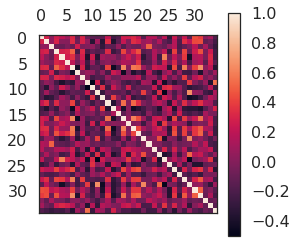

In [12]:
## plot RDM collapsing across all ages
sns.set_style('white')
fig = plt.figure(figsize=(6,6))
labels = KM.label.values
means = get_class_means(KF, labels)
CORRMAT = np.corrcoef(means)
plt.matshow(CORRMAT)
plt.colorbar()

(35, 35)


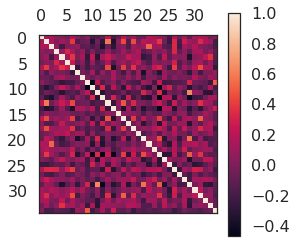

In [13]:
## get RDM for older kids (7,8,9,10)
ind = KM.index[KM['coarse_age'] == 'older']
meta = KM.loc[ind]
feat = KF[ind.tolist()]
sns.set_style('white')
fig = plt.figure(figsize=(6,6))
labels = meta.label.values
means = get_class_means(feat, labels)
CORRMAT = np.corrcoef(means)
print(CORRMAT.shape)
plt.matshow(CORRMAT)
plt.colorbar()
CORRMAT1 = CORRMAT

(35, 35)


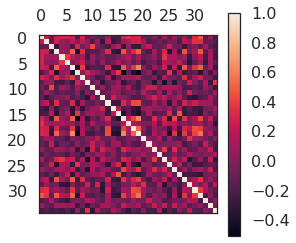

In [14]:
## get RDM for young kids (3,4,5,6)
ind = KM.index[KM['coarse_age'] == 'younger']
subY = KM.loc[ind]
subFeat = KF[ind.tolist()]

meta = subY
feat = subFeat
sns.set_style('white')
fig = plt.figure(figsize=(6,6))
labels = meta.label.values
means = get_class_means(feat, labels)
CORRMAT = np.corrcoef(means)
print(CORRMAT.shape)
plt.matshow(CORRMAT)
plt.colorbar()
CORRMAT2 = CORRMAT

In [ ]:
import scipy.stats as stats
stats.spearmanr(np.ravel(CORRMAT1),np.ravel(CORRMAT2))

### Extract adult drawing features

In [8]:
## load in adult features
AF, AM = load_features('adult',6)
AF, AM = remove_practice_trials(AF, AM)
AM = AM.reset_index(drop=True)
print np.shape(AF)

(38000, 4096)


In [15]:
## set up lookup table to cover discrepancies in category label assignments
lookup = dict(zip(common_labels,common_labels))
lookup['bike'] = 'bicycle'

In [16]:
AF, AM = subset_common_labels(AF, AM, [lookup[i] for i in common_labels])
AM = AM.reset_index(drop=True)

In [85]:
def flatten(x):
    return [item for sublist in x for item in sublist]

from sklearn.cluster import AffinityPropagation
from sklearn import metrics

af = AffinityPropagation(damping=0.5).fit(means)
labels = af.labels_
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)

ordered_objs = []
print('Clusters')
for k in range(n_clusters_):
    class_members = labels == k
    print _labels[class_members]
    ordered_objs.append(list(_labels[class_members]))
    
ordered_objs = np.array(flatten(ordered_objs)    )

Clusters
['airplane' 'boat' 'carrot' 'cat' 'couch' 'fork' 'ice cream' 'shark']
['bed' 'chair' 'piano' 'table']
['bus' 'train']
['cookie']
['bear' 'bicycle' 'bird' 'car' 'dog' 'duck' 'flower' 'frog' 'keys' 'rabbit'
 'sheep']
['door' 'phone']
['apple' 'banana' 'cup' 'fish' 'foot' 'hat' 'shoe']


In [108]:
## retrieve alpha sorted labels from meta
_labels = np.unique(AM.label.values)
## index for sorting the alphabetical list of labels INTO the order specified by ordered_objs (clustered)
sort_inds = [np.where(_labels==ordered_objs[i])[0][0] for i in np.arange(len(ordered_objs))]

In [143]:
## sorted adult RDMs
labels = AM.label.values
adult_means = get_class_means(AF, labels)
ordered_means = adult_means[sort_inds,:]
sns.set_style('white')
CORRMAT = np.corrcoef(ordered_means)

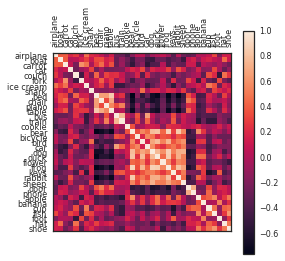

In [157]:
sns.set_context('paper')
fig = plt.figure(figsize=(24,24))
plt.matshow(CORRMAT)
plt.xticks(range(len(ordered_objs)), ordered_objs, rotation=90);
plt.yticks(range(len(ordered_objs)), ordered_objs); 
plt.colorbar(ax)
for tick in pylab.gca().xaxis.iter_ticks():
    tick[0].label2On = True
    tick[0].label1On = False
    tick[0].label2.set_rotation('vertical')
    tick[0].tick1On = False
    tick[0].tick2On = False
for tick in pylab.gca().yaxis.iter_ticks():
    tick[0].tick1On = False
    tick[0].tick2On = False  
ARDM = CORRMAT

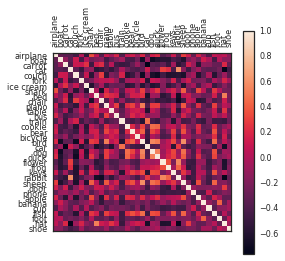

In [158]:
## plot sorted kid RDM collapsing across all ages
sns.set_style('white')
fig = plt.figure(figsize=(6,6))
labels = KM.label.values
kid_means = get_class_means(KF, labels)
ordered_means = kid_means[sort_inds,:]
CORRMAT = np.corrcoef(ordered_means)
plt.matshow(CORRMAT)
plt.xticks(range(len(ordered_objs)), ordered_objs, rotation=90);
plt.yticks(range(len(ordered_objs)), ordered_objs); 
plt.colorbar(ax)
for tick in pylab.gca().xaxis.iter_ticks():
    tick[0].label2On = True
    tick[0].label1On = False
    tick[0].label2.set_rotation('vertical')
    tick[0].tick1On = False
    tick[0].tick2On = False
for tick in pylab.gca().yaxis.iter_ticks():
    tick[0].tick1On = False
    tick[0].tick2On = False  
KRDM = CORRMAT

In [159]:
import scipy.stats as stats
stats.spearmanr(np.ravel(ARDM),np.ravel(KRDM))

SpearmanrResult(correlation=0.4090767761648465, pvalue=1.2863875329655047e-50)

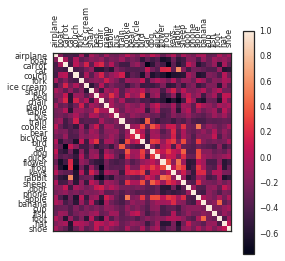

In [160]:
## get RDM for older kids (7,8,9,10)
ind = KM.index[KM['coarse_age'] == 'older']
meta = KM.loc[ind]
feat = KF[ind.tolist()]
sns.set_style('white')
fig = plt.figure(figsize=(6,6))
labels = meta.label.values
older_means = get_class_means(feat, labels)
ordered_means = older_means[sort_inds,:]
CORRMAT = np.corrcoef(ordered_means)
plt.matshow(CORRMAT)
plt.xticks(range(len(ordered_objs)), ordered_objs, rotation=90);
plt.yticks(range(len(ordered_objs)), ordered_objs); 
plt.colorbar(ax)
for tick in pylab.gca().xaxis.iter_ticks():
    tick[0].label2On = True
    tick[0].label1On = False
    tick[0].label2.set_rotation('vertical')
    tick[0].tick1On = False
    tick[0].tick2On = False
for tick in pylab.gca().yaxis.iter_ticks():
    tick[0].tick1On = False
    tick[0].tick2On = False  
ORDM = CORRMAT

In [138]:
import scipy.stats as stats
stats.spearmanr(np.ravel(ARDM),np.ravel(ORDM))

SpearmanrResult(correlation=0.487743766415073, pvalue=3.320700067096611e-74)

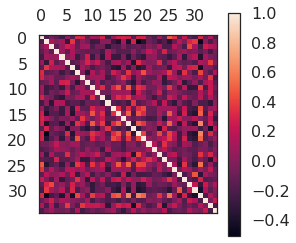

In [139]:
## get RDM for older kids (7,8,9,10)
ind = KM.index[KM['coarse_age'] == 'younger']
meta = KM.loc[ind]
feat = KF[ind.tolist()]
sns.set_style('white')
fig = plt.figure(figsize=(6,6))
labels = meta.label.values
younger_means = get_class_means(feat, labels)
ordered_means = younger_means[sort_inds,:]
CORRMAT = np.corrcoef(ordered_means)
plt.matshow(CORRMAT)
plt.colorbar()
YRDM = CORRMAT

In [141]:
import scipy.stats as stats
stats.spearmanr(np.ravel(YRDM),np.ravel(ARDM))

SpearmanrResult(correlation=0.24081619888882802, pvalue=1.2738862493261393e-17)